In [28]:
#!/usr/bin/env python
# coding: utf-8


import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score, recall_score


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def cal(y,oof_lgb,p=0.5):
    print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
    print("F1 score: {}".format(f1_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Precision score: {}".format(precision_score(y, [1 if i >= p else 0 for i in oof_lgb])))
    print("Recall score: {}".format(recall_score(y, [1 if i >= p else 0 for i in oof_lgb])))

In [29]:
def ks_calc_cross(data,pred,y_label):
    crossfreq = pd.crosstab(data[pred[0]],data[y_label[0]])
    crossdens = crossfreq.cumsum(axis=0) / crossfreq.sum()
    crossdens['gap'] = abs(crossdens[0] - crossdens[1])
    ks = crossdens[crossdens['gap'] == crossdens['gap'].max()]
    return ks,crossdens

def ks_calc_auc(data,pred,y_label):
    fpr,tpr,thresholds= roc_curve(data[y_label[0]],data[pred[0]])
    ks = max(tpr-fpr)
    return ks

def ks_calc_2samp(data,pred,y_label):
    Bad = data.loc[data[y_label[0]]==1,pred[0]]
    Good = data.loc[data[y_label[0]]==0, pred[0]]
    data1 = Bad.values
    data2 = Good.values
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1,data2])
    cdf1 = np.searchsorted(data1,data_all,side='right')/(1.0*n1)
    cdf2 = (np.searchsorted(data2,data_all,side='right'))/(1.0*n2)
    ks = np.max(np.absolute(cdf1-cdf2))
    cdf1_df = pd.DataFrame(cdf1)
    cdf2_df = pd.DataFrame(cdf2)
    cdf_df = pd.concat([cdf1_df,cdf2_df],axis = 1)
    cdf_df.columns = ['cdf_Bad','cdf_Good']
    cdf_df['gap'] = cdf_df['cdf_Bad']-cdf_df['cdf_Good']
    return ks,cdf_df

In [63]:
train_data_list = ['training_raw data_1.xlsx','training_raw data_0.xlsx']
train_data = pd.DataFrame()
for file in train_data_list:
    _ = pd.read_excel('../data/{}'.format(file))
    if '1' in file:
        _['label'] = 1
        label2 = _.iloc[:,0].values
        _ = _.iloc[:,1:]
    else:
        _['label'] = 0
        _ = _.iloc[:,1:]
    _.columns = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U', 'label']
    train_data = pd.concat([train_data,_], axis=0)
train_data = train_data.reset_index(drop=True) 

valid = pd.read_excel('../data/{}'.format('application data.xlsx'))
valid['label']=np.nan

print('#'*20)
print('miss rate_training data')
print(train_data.isnull().sum() / (valid.shape[0]))
print('#'*20)
print('miss rate_application data')
print(valid.isnull().sum() / (valid.shape[0]))

####################
miss rate_training data
TI       0.198646
Y        0.169900
NB       0.331628
LA       0.082116
CE       0.000000
CE*      0.194634
PR       0.152527
ND       0.008613
SM       0.017041
EU       0.006956
EU*      0.024219
GD       0.023888
TB       0.081048
DY       0.005705
HO       0.076374
ER       0.022636
TM       0.095992
YB       0.033862
LU       0.046156
HF       0.161140
TA       0.406088
TH       0.118885
U        0.113843
label    0.000000
dtype: float64
####################
miss rate_application data
TI       0.154220
Y        0.082300
NB       0.216497
LA       0.137399
CE       0.001141
CE*      0.365527
PR       0.029777
ND       0.010416
SM       0.000626
EU       0.001951
EU*      0.006404
GD       0.000221
TB       0.040414
DY       0.000074
HO       0.020575
ER       0.000478
TM       0.104715
YB       0.000000
LU       0.000037
HF       0.039972
TA       0.391292
TH       0.010674
U        0.004932
label    1.000000
dtype: float64


In [32]:
df_label = pd.read_excel('../res/training data_label.xlsx')

In [72]:
df_label_valid = pd.read_excel('../res/application data_label.xlsx')

In [35]:
train_data.shape, df_label.shape

((20923, 24), (20923, 123))

In [37]:
df_label.columns

Index(['CE**EU*EU', 'YB/LU', 'NB/LA/CE*', 'TM/YB', 'Y/LA/TB', 'ER/YB', 'TH/U',
       'EU**EU**TA', 'ER/TM', 'PR/ND/EU*',
       ...
       'NB/HF/TA', 'NB/TA', 'TB/DY/HF', 'NB-TA-TA', 'SM/GD/HF', 'EU/EU*/GD',
       'CE/TH', 'label', 'prob', 'pred'],
      dtype='object', length=123)

In [85]:
train_data['pred'] = df_label['pred']
train_data = train_data[(train_data['label']==1)]
train_data['label2'] = label2

train_data = train_data[(train_data['label']==1)&(train_data['pred']==1)].reset_index(drop=True)

In [86]:
train_data['label2'].value_counts()

3    1563
2     263
1     151
Name: label2, dtype: int64

In [87]:
valid['pred'] = df_label_valid['pred']
valid = valid[(valid['pred']==1)]

In [88]:
valid

,TI,Y,NB,LA,CE,CE*,PR,ND,SM,EU,...,TA*TA*U,TA/TA/U,TA+TH+TH,TA-TH-TH,TA*TH*TH,TA/TH/TH,TA+TH+U,TA-TH-U,TA*TH*U,TA/TH/U
23,-99.000,-99.000,-99.000,0.0155,1.720,13.658707,0.0615,0.951,1.560,0.647,...,1.507394e+06,0.006502,112.600,-310.600,-1.108170e+06,-0.008844,160.600,-358.600,-1.610932e+06,-0.006084
24,-99.000,-99.000,-99.000,0.0670,0.860,3.505490,0.0540,0.670,2.900,1.690,...,1.516215e+07,0.000646,-79.940,-118.060,-8.991269e+03,-1.090057,1457.530,-1655.530,-1.459548e+06,-0.006715
416,0.001,116.300,0.557,-99.0000,7.240,-99.000000,0.0250,0.270,0.450,0.300,...,1.620105e+06,0.006050,124.600,-322.600,-1.237425e+06,-0.007920,178.100,-376.100,-1.829573e+06,-0.005357
728,44.795,148.268,7.362,0.0290,3.143,16.523396,0.0750,0.646,0.750,0.302,...,7.651337e+02,0.004434,40.676,-36.992,6.944706e+02,0.004886,246.765,-243.081,8.065473e+03,0.000421
729,7.234,3314.300,37.593,0.0650,20.243,18.881484,1.0630,12.721,23.589,1.146,...,7.204866e+03,0.003943,506.264,-495.604,3.343707e+05,0.000085,509.410,-498.750,3.385706e+05,0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27150,41.400,429.000,2.630,0.0130,8.550,52.423551,0.1230,1.260,2.280,0.910,...,2.095040e+02,0.009625,224.820,-221.980,1.771718e+04,0.000114,217.020,-214.180,1.647999e+04,0.000122
27156,20.500,2030.000,18.160,0.0600,131.500,246.554113,0.2850,5.440,10.110,3.390,...,1.774108e+03,0.014205,240.420,-230.380,6.954352e+04,0.000362,193.120,-183.080,4.159612e+04,0.000606
27157,86.800,551.000,3.450,0.0750,19.980,25.121492,0.5070,6.140,6.390,2.700,...,3.568738e+02,0.012240,346.090,-341.910,6.183056e+04,0.000071,255.790,-251.610,2.936952e+04,0.000149
27158,20.000,2119.000,17.930,0.0490,178.300,313.826970,0.3960,6.220,10.350,3.780,...,3.359192e+03,0.007622,619.060,-608.940,4.768999e+05,0.000054,443.260,-433.140,2.038087e+05,0.000126


In [89]:
feas = ['TI', 'Y', 'NB', 'LA', 'CE', 'CE*', 'PR', 'ND', 'SM', 'EU', 'EU*', 'GD', 'TB', 'DY',
       'HO', 'ER', 'TM', 'YB', 'LU', 'HF', 'TA', 'TH', 'U']
for fea in feas:
    train_data['{}_isnull'.format(fea)] = 0
    valid['{}_isnull'.format(fea)] = 0
    train_data.loc[train_data[fea].isnull(), '{}_isnull'.format(fea)] =1
    valid.loc[valid[fea].isnull(), '{}_isnull'.format(fea)] =1

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [90]:
train_data = train_data.fillna(-99)
valid = valid.fillna(-99)

In [91]:
X_train, X_test = train_test_split(train_data, test_size=0.3, random_state=42)
#X_train.to_excel('../res/training_set.xlsx', index=True)
#X_test.to_excel('../res/test_set.xlsx', index=True)

In [92]:
feas_expode = []
for i in range(len(feas)-1):
    for j in range(i,len(feas)):
        for data in [train_data,valid]:
            data['{}+{}'.format(feas[i],feas[j])] = data[feas[i]]+data[feas[j]]
            data['{}-{}'.format(feas[i],feas[j])] = data[feas[i]]-data[feas[j]]
            data['{}*{}'.format(feas[i],feas[j])] = data[feas[i]]*data[feas[j]]
            data['{}/{}'.format(feas[i],feas[j])] = data[feas[i]]/(data[feas[j]]+1e-10)
#           data['{}^{}'.format(feas[i],feas[j])] = data[feas[i]]**(train_data[feas[j]]+1e-10)

In [93]:
for i in tqdm(range(len(feas)-2)):
    for j in range(i,len(feas)-1):
        for k in range(j,len(feas)):
            for data in [train_data,valid]:
                data['{}+{}+{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]+data[feas[j]]+data[feas[k]]
                data['{}-{}-{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]-data[feas[j]]-data[feas[k]]
                data['{}*{}*{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]*data[feas[j]]*data[feas[k]]
                data['{}/{}/{}'.format(feas[i],feas[j],feas[k])] = data[feas[i]]/(data[feas[j]]+1e-10)/(data[feas[k]]+1e-10)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/21 [00:00<?, ?it/s]

In [115]:
train, test = train_test_split(train_data, test_size=0.3, random_state=42)

In [180]:
params = {
    'learning_rate': 0.01,
    'min_child_samples': 5,
#     'num_leaves': 63,
    'max_depth': 7,
    'lambda_l1': 0.5,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'n_estimators': 2000,
    'metric': 'multi_error',
    'num_class': 6,
    'feature_fraction': .75,
    'bagging_fraction': .85,
    'seed': 1,
    'is_unbalance':True,
#     'num_threads': 20,
#     'verbose': -1
}

In [181]:
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,confusion_matrix,classification_report
eval_fun = f1_score
def run_oof(clf, feas_all, feas_cat, X_train, y_train, X_test, kf):
#     print(clf)
    
    model_lst = []
    df_impt = pd.DataFrame()
    preds_train = np.zeros((len(X_train), 3), dtype = np.float)
    preds_test = np.zeros((len(X_test), 3), dtype = np.float)
    train_loss = []; test_loss = []

    i = 1
    for train_index, test_index in kf.split(X_train, y_train):
        x_tr = X_train[train_index]; x_te = X_train[test_index]
        y_tr = y_train[train_index]; y_te = y_train[test_index]
        model = clf.fit(x_tr, y_tr, eval_set = [(x_te, y_te)],
                        categorical_feature=feas_cat,
                        early_stopping_rounds = 500, verbose = 200)
        
        train_loss.append(eval_fun(y_tr, np.argmax(model.predict_proba(x_tr)[:], 1), average='macro'))
        test_loss.append(eval_fun(y_te, np.argmax(model.predict_proba(x_te)[:], 1), average='macro'))

        preds_train[test_index] = model.predict_proba(x_te)[:]
        preds_test += model.predict_proba(X_test)[:]
        
        df_impt_ = pd.DataFrame()
        df_impt_['fea'] = feas_all
        df_impt_['impt'] = model.feature_importances_
        df_impt_['fold'] = i
        
        df_impt = pd.concat([df_impt,df_impt_], axis=0)
        
        print('{0}: Train {1:0.7f} Val {2:0.7f}/{3:0.7f}'.format(i, train_loss[-1], test_loss[-1], np.mean(test_loss)))
        print('-' * 50)
        i += 1
        model_lst.append(model)
        
    df_impt = df_impt.groupby(['fea'])['impt'].mean().reset_index()
    print('Val_f1: ', test_loss)
    print('Val_f1_mean: ', np.mean(test_loss))
    print('Val_std: ', np.std(test_loss))
    print('-' * 50)
    preds_test /= n_fold
    return preds_train, preds_test, df_impt, test_loss,model_lst

In [182]:
y = train['label2']-1
y_test = test['label2']-1
cat_cols = []

In [183]:
cols_flt = ['CE**EU*EU', 'YB/LU', 'NB/LA/CE*', 'TM/YB', 'Y/LA/TB', 'ER/YB', 'TH/U', 'EU**EU**TA', 'ER/TM', 'PR/ND/EU*', 'LU/TH', 'HO-LU', 'TI*TI*CE', 'TB/DY', 'TH-U', 'DY/HO', 'TA/U', 'Y/CE*/TH', 'NB*EU**U', 'Y/CE*/EU', 'TI*TI*DY', 'Y/DY/HF', 'HF-U', 'ND-EU-EU', 'TI*EU**U', 'CE**ND*HF', 'NB/LU/TA', 'EU/GD', 'Y*HF*TA', 'Y/CE/EU*', 'Y/YB/TH', 'YB/LU/HF', 'CE-ND-TA', 'PR/ND/TA', 'SM/GD', 'TI/NB/EU*', 'GD/TB', 'CE/U', 'Y/NB', 'Y*EU**HF', 'TI*TI*U', 'HO/ER', 'LA+EU*+TA', 'CE/DY/U', 'CE/EU/TA', 'TI*TI*TA', 'TI/EU*/HF', 'TI*Y*TA', 'CE/HF/HF', 'CE/GD', 'TI*EU*HF', 'CE/HF/TH', 'CE/GD/HF', 'CE/EU*/TH', 'TI*Y*EU*', 'TI*HF*HF', 'EU**HF*TA', 'HF-TH-U', 'EU/GD/HF', 'YB/LU/TA', 'CE/EU*', 'NB/CE/CE', 'Y/CE/U', 'CE/DY/DY', 'Y/TH', 'PR/EU/TA', 'CE/EU*/EU*', 'EU**HF*HF', 'Y/TM', 'Y/HO', 'Y/NB/EU*', 'NB/HF/U', 'ER-LU-LU', 'HO-LU-TA', 'TI*NB*TA', 'Y/EU*/U', 'Y/ER', 'Y/NB/ER', 'TI/EU*/TA', 'HO/TM', 'CE/TA/TH', 'TM/YB/HF', 'TI*HF*TA', 'TB/LU/HF', 'ER/LU', 'Y/DY/TA', 'DY-LU-LU', 'CE/EU/TH', 'ER/TM/HF', 'TA*U', 'TM/LU', 'NB/HF/TH', 'CE*EU**HF', 'Y*CE*EU*', 'Y/NB/YB', 'ND-EU-EU*', 'NB/TH/U', 'CE/TA/U', 'Y/SM', 'TI/HF/HF', 'Y/YB', 'TI/HF', 'EU*/TA/TA', 'CE/EU/HF', 'DY-LU-TA', 'CE/SM/HF', 'DY/LU', 'ER/YB/HF', 'Y/DY', 'Y/NB/CE', 'SM/EU/TA', 'CE/EU/EU*', 'CE/EU*/U', 'NB/HF/TA', 'NB/TA', 'TB/DY/HF', 'NB-TA-TA', 'SM/GD/HF', 'EU/EU*/GD', 'CE/TH']
y_train = y.values
X_test = test[cols_flt].values

n_fold = 5
seed = 42
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state=seed)
train_pred, test_pred, df_impt, test_loss, model_lst = run_oof(lgb.LGBMClassifier(**params), 
                                cols_flt,
                                [],
                                X_train, 
                                y_train, 
                                X_test, 
                                skf,
                               )

D:\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 500 rounds
[200]	valid_0's multi_error: 0.0180505
[400]	valid_0's multi_error: 0.0144404
[600]	valid_0's multi_error: 0.0144404
Early stopping, best iteration is:
[228]	valid_0's multi_error: 0.0144404
1: Train 1.0000000 Val 0.9618820/0.9618820
--------------------------------------------------
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will 

D:\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	valid_0's multi_error: 0.0541516
[400]	valid_0's multi_error: 0.0541516
[600]	valid_0's multi_error: 0.0541516
Early stopping, best iteration is:
[151]	valid_0's multi_error: 0.0505415
2: Train 0.9978128 Val 0.8537790/0.9078305
--------------------------------------------------
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 500 rounds


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	valid_0's multi_error: 0.0505415
[400]	valid_0's multi_error: 0.032491
[600]	valid_0's multi_error: 0.0288809
[800]	valid_0's multi_error: 0.0288809
Early stopping, best iteration is:
[477]	valid_0's multi_error: 0.0288809
3: Train 1.0000000 Val 0.9351758/0.9169456
--------------------------------------------------
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 500 rounds


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	valid_0's multi_error: 0.0326087
[400]	valid_0's multi_error: 0.0326087
[600]	valid_0's multi_error: 0.0326087
Early stopping, best iteration is:
[267]	valid_0's multi_error: 0.0289855
4: Train 1.0000000 Val 0.9303917/0.9203071
--------------------------------------------------
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 500 rounds


D:\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[200]	valid_0's multi_error: 0.0326087
[400]	valid_0's multi_error: 0.0289855
[600]	valid_0's multi_error: 0.0326087
[800]	valid_0's multi_error: 0.0326087
Early stopping, best iteration is:
[399]	valid_0's multi_error: 0.0289855
5: Train 1.0000000 Val 0.9327052/0.9227867
--------------------------------------------------
Val_f1:  [0.9618819776714513, 0.8537790460660416, 0.9351757817130123, 0.9303917285568661, 0.9327052045545526]
Val_f1_mean:  0.9227867477123848
Val_std:  0.03633235355796976
--------------------------------------------------


In [184]:
X_valid = valid[cols_flt].values
preds_valid = np.zeros((len(X_valid), 3), dtype = np.float)
for i in range(5):
    preds_valid += model_lst[i].predict_proba(X_valid)[:]

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [242]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title ,fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45 ,fontsize=10)
    plt.yticks(tick_marks, classes ,fontsize=10)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black" ,fontsize=15)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.show()

In [246]:
print('#'*20)
print('train-f1:', eval_fun(y_train, np.argmax(train_pred, 1), average='macro'))
print('train-混淆矩阵')
print(classification_report(y_train, np.argmax(train_pred, 1)) )
print('#'*20)
print('test-f1:', eval_fun(y_test, np.argmax(test_pred, 1), average='macro'))
print('test-混淆矩阵')
print(classification_report(y_test, np.argmax(test_pred, 1)) )

####################
train-f1: 0.9247995277215862
train-混淆矩阵
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       105
           1       0.99      0.99      0.99       189
           2       0.97      0.99      0.98      1089

    accuracy                           0.97      1383
   macro avg       0.95      0.91      0.92      1383
weighted avg       0.97      0.97      0.97      1383

####################
test-f1: 0.9304484756865709
test-混淆矩阵
              precision    recall  f1-score   support

           0       0.94      0.72      0.81        46
           1       1.00      0.99      0.99        74
           2       0.97      1.00      0.98       474

    accuracy                           0.97       594
   macro avg       0.97      0.90      0.93       594
weighted avg       0.97      0.97      0.97       594



####################
train-混淆矩阵
显示百分比：
[[ 0.74  0.00  0.26]
 [ 0.00  0.99  0.01]
 [ 0.01  0.00  0.99]]


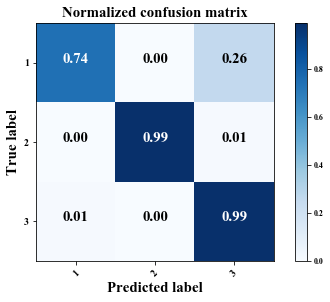

####################
test-混淆矩阵
显示百分比：
[[ 0.72  0.00  0.28]
 [ 0.00  0.99  0.01]
 [ 0.00  0.00  1.00]]


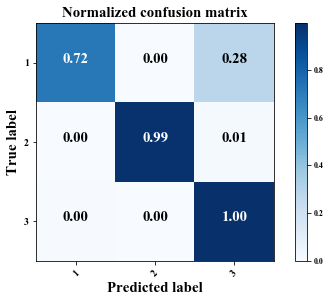

In [266]:
print('#'*20)
print('train-混淆矩阵')
cm = confusion_matrix(y_train, np.argmax(train_pred, 1))
plot_confusion_matrix(cm, classes=['1','2','3'], normalize=True, title='Normalized confusion matrix')

print('#'*20)
print('test-混淆矩阵')
cm = confusion_matrix(y_test, np.argmax(test_pred, 1))
plot_confusion_matrix(cm, classes=['1','2','3'], normalize=True, title='Normalized confusion matrix')

In [270]:
train['pred_stage2'] = np.argmax(train_pred, 1)+1
test['pred_stage2'] = np.argmax(test_pred, 1)+1

In [271]:
valid_pred = np.argmax(preds_valid, 1)
valid['pred_stage2'] = valid_pred+1

In [274]:
cols_output = features_slc + ['label2','pred_stage2']
train[cols_output].to_excel('../res_stage2/train.xlsx', index=False)
test[cols_output].to_excel('../res_stage2/test.xlsx', index=False)

valid[[f for f in cols_output if f not in ['label2']]].to_excel('../res_stage2/valid.xlsx', index=False)

df_feature_importance.sort_values(by='gain', ascending=False).to_excel('../res/feature importance.xlsx', index=False)

In [275]:
print('#'*20)
print('feature importance：')
print(df_feature_importance.sort_values(by='gain', ascending=False).head(10))

####################
feature importance：
     features   gain
8       ER/TM  240.8
3       TM/YB  230.8
1       YB/LU  223.6
6        TH/U  198.8
0   CE**EU*EU  195.2
35  TI/NB/EU*  193.8
5       ER/YB  191.6
4     Y/LA/TB  175.2
31   YB/LU/HF  175.0
17   Y/CE*/TH  174.4
